# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-f_tqkrp2
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-f_tqkrp2
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-wk8evje0/pyfolio_e22b01d22fcd45ff9100aa0bc7b0f4b1
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-wk8evje0/pyfolio_e22b01d22fcd45ff9100aa0bc7b0f4b1
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-wk8evje0/elegantrl_06971a9db38e43dc89bbd45feb71580f
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-wk8evje0/elegantrl_06971a9db38e43dc89bbd45feb71580f
     |████████████████████████████████| 234 kB 27.6 MB/s 
     |████████████████████████████████| 176 kB 61.6 MB/s 
     |████████████████████████████████| 59.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 69.2 MB/s 
     |████


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [113]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [7]:
config.END_DATE

'2021-10-31'

In [6]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.775245,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615871,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.579439,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941105,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.318970,7117200,CAT,4


In [10]:
df.tail()

,date,open,high,low,close,volume,tic,day
91836,2021-07-02,405.089996,409.869995,403.880005,406.601990,1982400,UNH,4
91837,2021-07-02,235.830002,238.779999,235.820007,237.886353,4383700,V,4
91838,2021-07-02,56.380001,56.570000,56.259998,54.501297,11387100,VZ,4
91839,2021-07-02,49.110001,49.139999,47.570000,47.243721,15863200,WBA,4
91840,2021-07-02,139.350006,141.080002,139.350006,139.036484,8760200,WMT,4


In [11]:
df.shape

(91841, 8)

In [12]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.775245,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615871,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.579439,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941105,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.318970,7117200,CAT,4


In [13]:
len(df.tic.unique())

30

In [14]:
df.tic.value_counts()

AAPL    3147
AMGN    3147
WMT     3147
WBA     3147
VZ      3147
V       3147
UNH     3147
TRV     3147
PG      3147
NKE     3147
MSFT    3147
MRK     3147
MMM     3147
MCD     3147
KO      3147
JPM     3147
JNJ     3147
INTC    3147
IBM     3147
HON     3147
HD      3147
GS      3147
DIS     3147
CVX     3147
CSCO    3147
CRM     3147
CAT     3147
BA      3147
AXP     3147
DOW      578
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [15]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
6976,2009-12-15,29.575001,29.594999,29.424999,20.341900,15299800,KO,1,0.343242,68.374149,118.819949,29.634085,0.000000
90353,2021-05-19,201.910004,202.699997,199.330002,197.985153,2220200,MMM,2,2.203866,58.016234,43.736349,6.728426,11.222522
18402,2011-07-11,33.875000,34.139999,33.855000,24.546127,14152400,KO,0,0.241988,57.897126,117.670951,12.724517,11.238338
33166,2013-07-19,45.295803,45.725189,45.038170,34.919746,14911678,MRK,4,0.209517,53.933314,14.038719,2.829679,211.112286
10265,2010-05-28,50.750000,50.930000,50.500000,38.629822,14019500,WMT,4,-0.658119,39.089086,-128.508679,25.718342,31.217974


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [18]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [19]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [20]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2020-04-01'
val_test_start = '2020-04-01'
val_test_end = '2021-07-20'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [21]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [22]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.9289909804111
======Model training from:  2009-01-01 to  2020-04-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 59          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0.32        |
|    learning_rate      | 0.0005      |
|    n_updates          | 99          |
|    policy_loss        | -67         |
|    reward             | -0.15298374 |
|    std                | 1           |
|    value_loss         | 3.32        |
---------------------------------------
--------------------------------------
| time/                 |          

In [23]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-04-02,2020-07-02,PPO,0.258695,0.271096,0.224485
1,189,2020-07-02,2020-10-01,DDPG,-0.009252,0.236224,0.237741
2,252,2020-10-01,2020-12-31,A2C,0.240083,0.196659,0.185019
3,315,2020-12-31,2021-04-05,A2C,0.301743,0.223359,0.276478


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [24]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [25]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.7361686494141908


In [26]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-02,NaN,2020-07-02
1,1.002033e+06,2020-07-06,0.002033,2020-07-06
2,9.992879e+05,2020-07-07,-0.002739,2020-07-07
3,1.001908e+06,2020-07-08,0.002622,2020-07-08
4,9.981527e+05,2020-07-09,-0.003748,2020-07-09


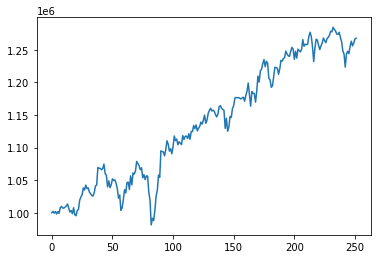

In [28]:
%matplotlib inline
df_account_value.account_value.plot()
plt.show()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.267947
Cumulative returns     0.267947
Annual volatility      0.143229
Sharpe ratio           1.736169
Calmar ratio           2.964940
Stability              0.940258
Max drawdown          -0.090372
Omega ratio            1.344333
Sortino ratio          2.655088
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.061660
Daily value at risk   -0.017058
dtype: float64


In [30]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.337432
Cumulative returns     0.335890
Annual volatility      0.146098
Sharpe ratio           2.072078
Calmar ratio           3.778308
Stability              0.944970
Max drawdown          -0.089308
Omega ratio            1.411593
Sortino ratio          3.102218
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078766
Daily value at risk   -0.017205
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2020-07-02
End date,2021-07-01
Total months,12
,Backtest
Annual return,26.795%
Cumulative returns,26.795%
Annual volatility,14.323%
Sharpe ratio,1.74
Calmar ratio,2.96
Stability,0.94
Max drawdown,-9.037%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.04,2020-10-12,2020-10-28,2020-11-09,21
1,6.61,2020-09-02,2020-09-23,2020-10-12,29
2,4.77,2021-06-04,2021-06-18,NaT,NaN
3,3.53,2021-05-07,2021-05-12,2021-06-02,19
4,3.45,2021-03-15,2021-03-23,2021-04-07,18


Stress Events,mean,min,max
New Normal,0.10%,-3.73%,3.85%


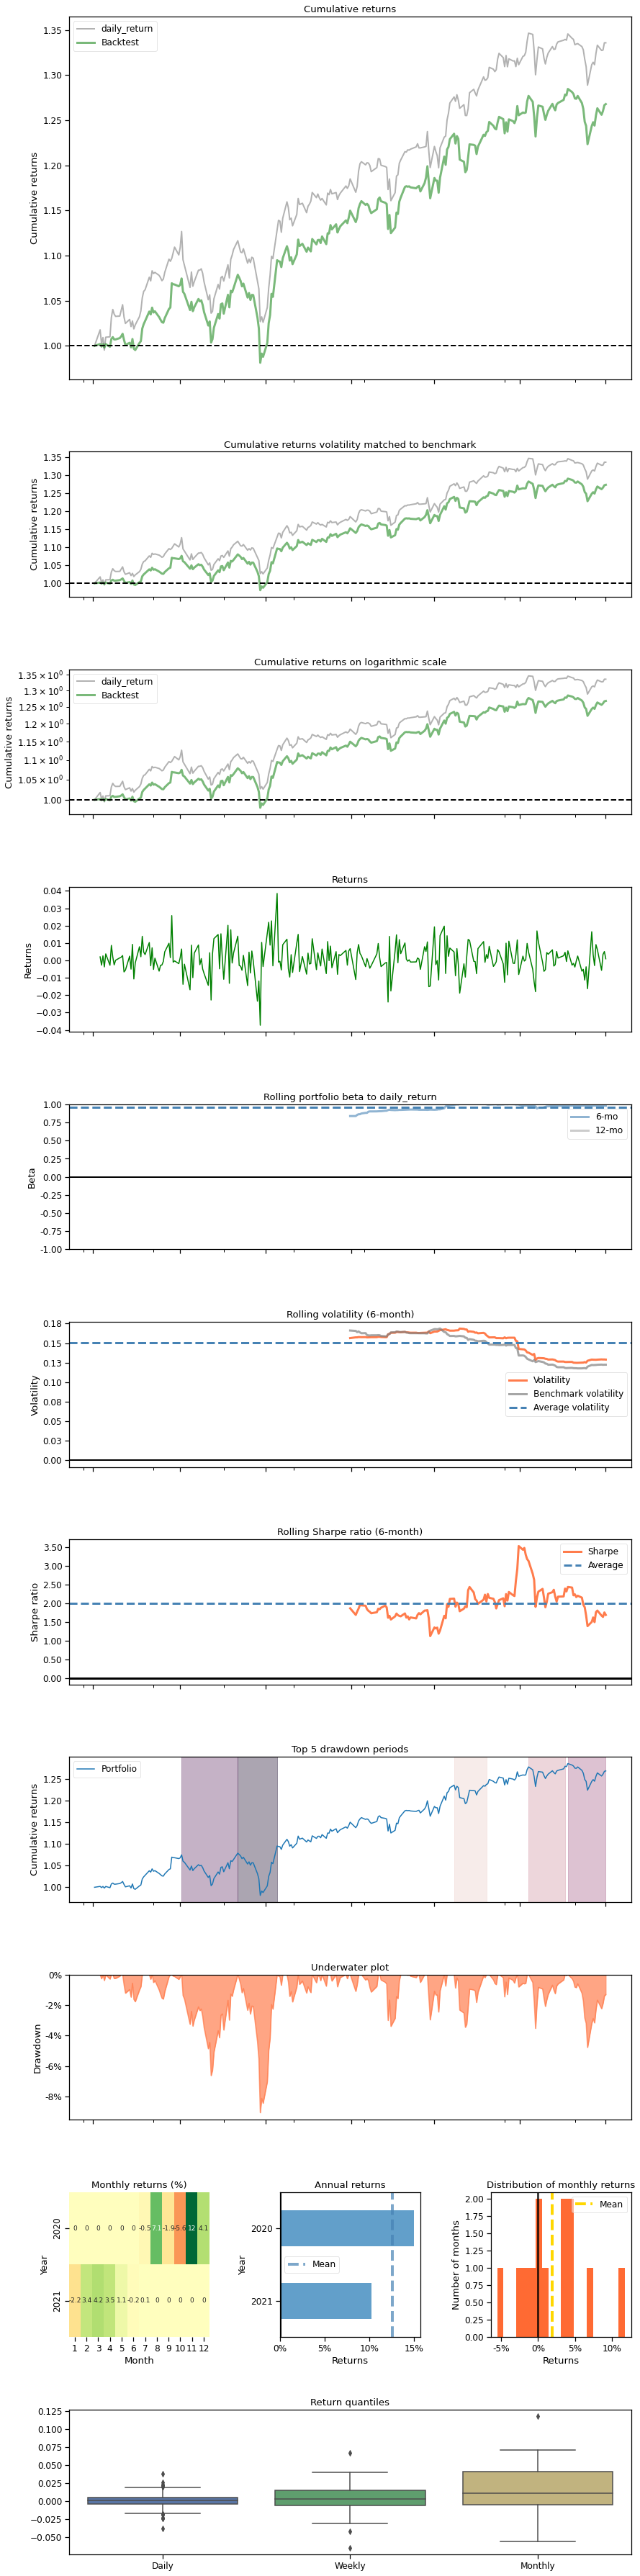

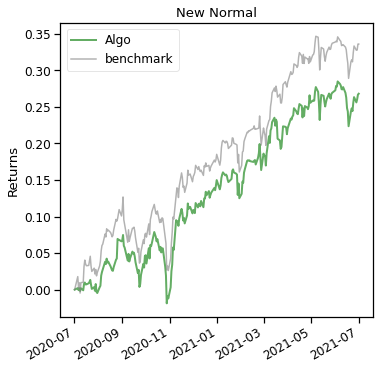

In [31]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

Let's do some practice with train and test/trade data and try some parameter tuning and see the results.

In [156]:
df_train_trade = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2022-02-08',
                     ticker_list = config.DOW_30_TICKER).fetch_data().sort_values(['date','tic'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [153]:
df_train_trade.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.775245,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615864,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.579438,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941082,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.318970,7117200,CAT,4


In [157]:
df_train_trade.tail()

,date,open,high,low,close,volume,tic,day
96366,2022-02-07,484.910004,487.260010,481.299988,483.700012,2935200,UNH,0
96367,2022-02-07,228.000000,229.919998,226.009995,227.160004,5932200,V,0
96368,2022-02-07,53.230000,53.360001,52.509998,53.000000,15233200,VZ,0
96369,2022-02-07,48.860001,49.459999,48.340000,49.090000,5009400,WBA,0
96370,2022-02-07,140.059998,140.070007,137.610001,137.960007,6534800,WMT,0


In [158]:
len(df_train_trade.tic.unique()), df_train_trade.tic.value_counts()

(30, AAPL    3298
 AMGN    3298
 WMT     3298
 WBA     3298
 VZ      3298
 V       3298
 UNH     3298
 TRV     3298
 PG      3298
 NKE     3298
 MSFT    3298
 MRK     3298
 MMM     3298
 MCD     3298
 KO      3298
 JPM     3298
 JNJ     3298
 INTC    3298
 IBM     3298
 HON     3298
 HD      3298
 GS      3298
 DIS     3298
 CVX     3298
 CSCO    3298
 CRM     3298
 CAT     3298
 BA      3298
 AXP     3298
 DOW      729
 Name: tic, dtype: int64)

In [161]:
## stockstats technical indicator column names
## check https://pypi.org/project/stockstats/ for different names
tech_indicators_train_trade = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]

In [160]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)
# train dataset Feature Engineering
processed_train_trade = fe.preprocess_data(df_train_trade)
processed_train_trade = processed_train_trade.copy()
processed_train_trade = processed_train_trade.fillna(0)
processed_train_trade = processed_train_trade.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [162]:
processed_train_trade.sample(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
77177,2019-07-31,144.990005,145.000000,142.339996,142.158295,9710700,DIS,2,1.330796,145.513507,138.599297,57.756602,58.476672,15.003769,141.000142,137.210951,82.050443
63603,2017-09-19,32.459999,32.650002,32.400002,28.387857,12927700,CSCO,1,0.212918,28.690338,27.014171,54.829511,125.544486,13.509210,27.716824,27.607754,33.537302
27629,2012-10-11,23.655001,23.867500,23.632500,21.370279,7937600,NKE,3,-0.139741,22.080068,21.021472,46.792555,-78.526027,24.345371,21.785077,21.577741,24.594180
36913,2014-01-23,57.915001,58.082500,56.915001,54.038975,13662400,V,3,1.200206,54.943596,50.728701,64.023818,121.456120,43.453083,51.815150,49.644654,30.853057
54201,2016-06-07,24.812500,24.967501,24.740000,23.030483,89638000,AAPL,1,0.039153,23.870103,20.885507,49.521433,83.988913,18.278452,22.270732,23.584592,18.697517
82758,2020-05-05,86.540001,88.529999,86.029999,85.970032,6321500,NKE,1,0.916565,89.024676,82.415555,50.120257,55.629844,10.901857,83.760978,85.262502,26.462221
41946,2014-10-01,181.558319,182.026764,178.575531,131.808289,3894467,IBM,2,-0.230271,137.071098,132.265138,45.445582,-209.590184,20.474578,134.753568,134.063467,20.955818
26013,2012-07-25,20.516430,20.742857,20.357143,17.583284,877312800,AAPL,2,0.126160,19.136371,17.512621,47.709169,-78.545437,18.730128,18.107619,17.709188,56.123530
75251,2019-04-25,160.520004,161.600006,158.550003,158.319626,8862500,V,3,2.314807,159.859494,152.491878,65.108556,96.921268,12.623632,154.733123,148.490237,393.723639
65566,2017-12-22,53.110001,53.630001,53.060001,44.120590,13657800,VZ,4,1.160980,45.349192,40.198632,64.705048,87.790918,53.218374,41.086590,40.530495,11.925810


In [163]:
stock_dimension_train_trade = len(processed_train_trade.tic.unique())
state_space_train_trade = 1 + 2*stock_dimension_train_trade + len(tech_indicators)*stock_dimension_train_trade

print(f"Stock Dimension Train Trade: {stock_dimension_train_trade}, State Space Train Trade: {state_space_train_trade}")

Stock Dimension Train Trade: 29, State Space Train Trade: 291


In [166]:
env_kwargs_train_trade = {
    "hmax": 100, 
    "initial_amount": 10000, 
    "buy_cost_pct": 0.0001, 
    "sell_cost_pct": 0.0001, 
    "state_space": state_space_train_trade, 
    "stock_dim": stock_dimension_train_trade, 
    "tech_indicator_list": tech_indicators_train_trade,
    "action_space": stock_dimension_train_trade, 
    "reward_scaling": 1e-5,
    "print_verbosity":7
}

In [168]:
rebalance_window_train_trade = 42 # rebalance_window is the number of days to retrain the model
validation_window_train_trade = 90 # validation_window is the number of days to do validation and trading (e.g. if validation_window=42, then both validation and trading period will be 42 days)
train_start_train_trade = '2009-01-01'
train_end_train_trade = '2019-01-01'
val_test_start_train_trade = '2019-01-01'
val_test_end_train_trade = '2022-02-08'

ensemble_agent_train_trade = DRLEnsembleAgent(df=processed_train_trade,
                 train_period=(train_start_train_trade,train_end_train_trade),
                 val_test_period=(val_test_start_train_trade,val_test_end_train_trade),
                 rebalance_window=rebalance_window_train_trade, 
                 validation_window=validation_window_train_trade, 
                 **env_kwargs_train_trade)

In [170]:
A2C_model_train_trade_kwargs = {
                    'n_steps': 10,
                    'ent_coef': 0.001,
                    'learning_rate': 0.005
                    }

PPO_model_train_trade_kwargs = {
                    "ent_coef":0.001,
                    "n_steps": 1024,
                    "learning_rate": 0.000025,
                    "batch_size": 42
                    }

DDPG_model_train_trade_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.00005,
                      "batch_size": 42
                    }

# SAC_model_train_trade_kwargs = {
#                       "batch_size": 42,
#                       "buffer_size": 100000,
#                       "learning_rate": 0.00001,
#                       "learning_starts": 100,
#                       "ent_coef": "auto_0.1",
#                   }
# ERL_model_train_trade_kwargs = {
#                       "learning_rate": 3e-6,
#                       "batch_size": 1024,
#                       "gamma": 0.985,
#                       "seed": 424,
#                       "net_dimension": 512,
#                       "target_step": 7000,
#                       "eval_gap": 30
#                   }

# timesteps_train_trade_dict = {'a2c' : 50_000, 
#                  'ppo' : 150_000, 
#                  'ddpg' : 20_000
#                  }


timesteps_train_trade_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [172]:
df_train_trade_summary = ensemble_agent_train_trade.run_ensemble_strategy(A2C_model_train_trade_kwargs,
                                                 PPO_model_train_trade_kwargs,
                                                 DDPG_model_train_trade_kwargs,
                                                 timesteps_train_trade_dict)

Предаденият резултат е скъсен до последните 5000 реда.
|    n_updates          | 599           |
|    policy_loss        | 0.0285        |
|    reward             | 0.00041530913 |
|    std                | 1.86          |
|    value_loss         | 4.15e-07      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 104           |
|    iterations         | 700           |
|    time_elapsed       | 66            |
|    total_timesteps    | 7000          |
| train/                |               |
|    entropy_loss       | -63.2         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.005         |
|    n_updates          | 699           |
|    policy_loss        | 0.447         |
|    reward             | -0.0004420199 |
|    std                | 2.16          |
|    value_loss         | 6.47e-05      |
-----------------------------------------
---------------------

In [173]:
df_train_trade_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,132,2019-01-02,2019-05-13,A2C,0.578533,-0.023345,0.215209
1,174,2019-03-05,2019-07-12,A2C,0.452488,0.297703,0.169459
2,216,2019-05-03,2019-09-11,PPO,-0.161151,-0.019974,-0.160082
3,258,2019-07-03,2019-11-08,PPO,0.024402,0.259254,0.156423
4,300,2019-09-03,2020-01-10,PPO,0.187569,0.211482,0.074983
5,342,2019-10-31,2020-03-12,DDPG,-0.042785,-0.109497,0.024102
6,384,2020-01-02,2020-05-12,A2C,-0.016918,-0.348045,-0.217648
7,426,2020-03-04,2020-07-13,A2C,0.059378,-0.116499,-0.048914
8,468,2020-05-04,2020-09-10,A2C,0.627159,0.228333,0.51374
9,510,2020-07-02,2020-11-09,DDPG,0.251066,0.156183,0.261068


In [174]:
unique_trade_date_train_trade = processed_train_trade[(processed_train_trade.date > val_test_start_train_trade)&(processed_train_trade.date <= val_test_end_train)].date.unique()

In [175]:
df_trade_date_train_trade = pd.DataFrame({'datadate':unique_trade_date_train_trade})

df_account_value_train_trade=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date_train_trade)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value_train_trade = df_account_value_train_trade.append(temp,ignore_index=True)
# print(df_account_value_train)
sharpe=(252**0.5)*df_account_value_train_trade.account_value.pct_change(1).mean()/df_account_value_train_trade.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_train_trade=df_account_value_train_trade.join(df_trade_date_train_trade[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.7684851796553549


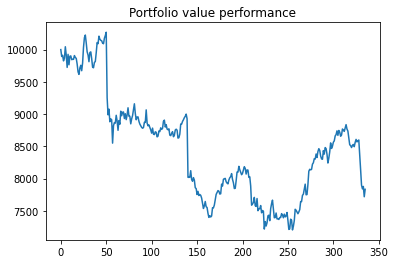

In [176]:
df_account_value_train_trade.account_value.plot()
plt.title("Portfolio value performance")
plt.show()

In [177]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_train_trade)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.167425
Cumulative returns    -0.216755
Annual volatility      0.209760
Sharpe ratio          -0.768485
Calmar ratio          -0.560603
Stability              0.450699
Max drawdown          -0.298652
Omega ratio            0.862252
Sortino ratio         -0.914242
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898823
Daily value at risk   -0.027067
dtype: float64


In [178]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value_train_trade.loc[0,'date'],
        end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.041362
Cumulative returns     0.055356
Annual volatility      0.152993
Sharpe ratio           0.342112
Calmar ratio           0.220338
Stability              0.672944
Max drawdown          -0.187719
Omega ratio            1.063903
Sortino ratio          0.466159
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.714481
Daily value at risk   -0.019068
dtype: float64


In [180]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value_train_trade.loc[0,'date'],
        end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.076777
Cumulative returns     0.103334
Annual volatility      0.153263
Sharpe ratio           0.560704
Calmar ratio           0.391032
Stability              0.761737
Max drawdown          -0.196345
Omega ratio            1.106793
Sortino ratio          0.767611
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.726799
Daily value at risk   -0.018968
dtype: float64


In [181]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^NDX", 
        start = df_account_value_train_trade.loc[0,'date'],
        end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.131656
Cumulative returns     0.178707
Annual volatility      0.204512
Sharpe ratio           0.708864
Calmar ratio           0.578519
Stability              0.784336
Max drawdown          -0.227574
Omega ratio            1.134347
Sortino ratio          0.985819
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.809763
Daily value at risk   -0.025191
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2018-10-02
End date,2020-02-03
Total months,16
,Backtest
Annual return,-16.743%
Cumulative returns,-21.675%
Annual volatility,20.976%
Sharpe ratio,-0.77
Calmar ratio,-0.56
Stability,0.45
Max drawdown,-29.865%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.87,2018-12-13,2019-10-08,NaT,NaN
1,4.97,2018-11-08,2018-11-21,2018-12-13,26
2,4.27,2018-10-09,2018-10-30,2018-11-07,22
3,1.75,2018-10-02,2018-10-05,2018-10-09,6
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,-0.06%,-10.17%,3.16%


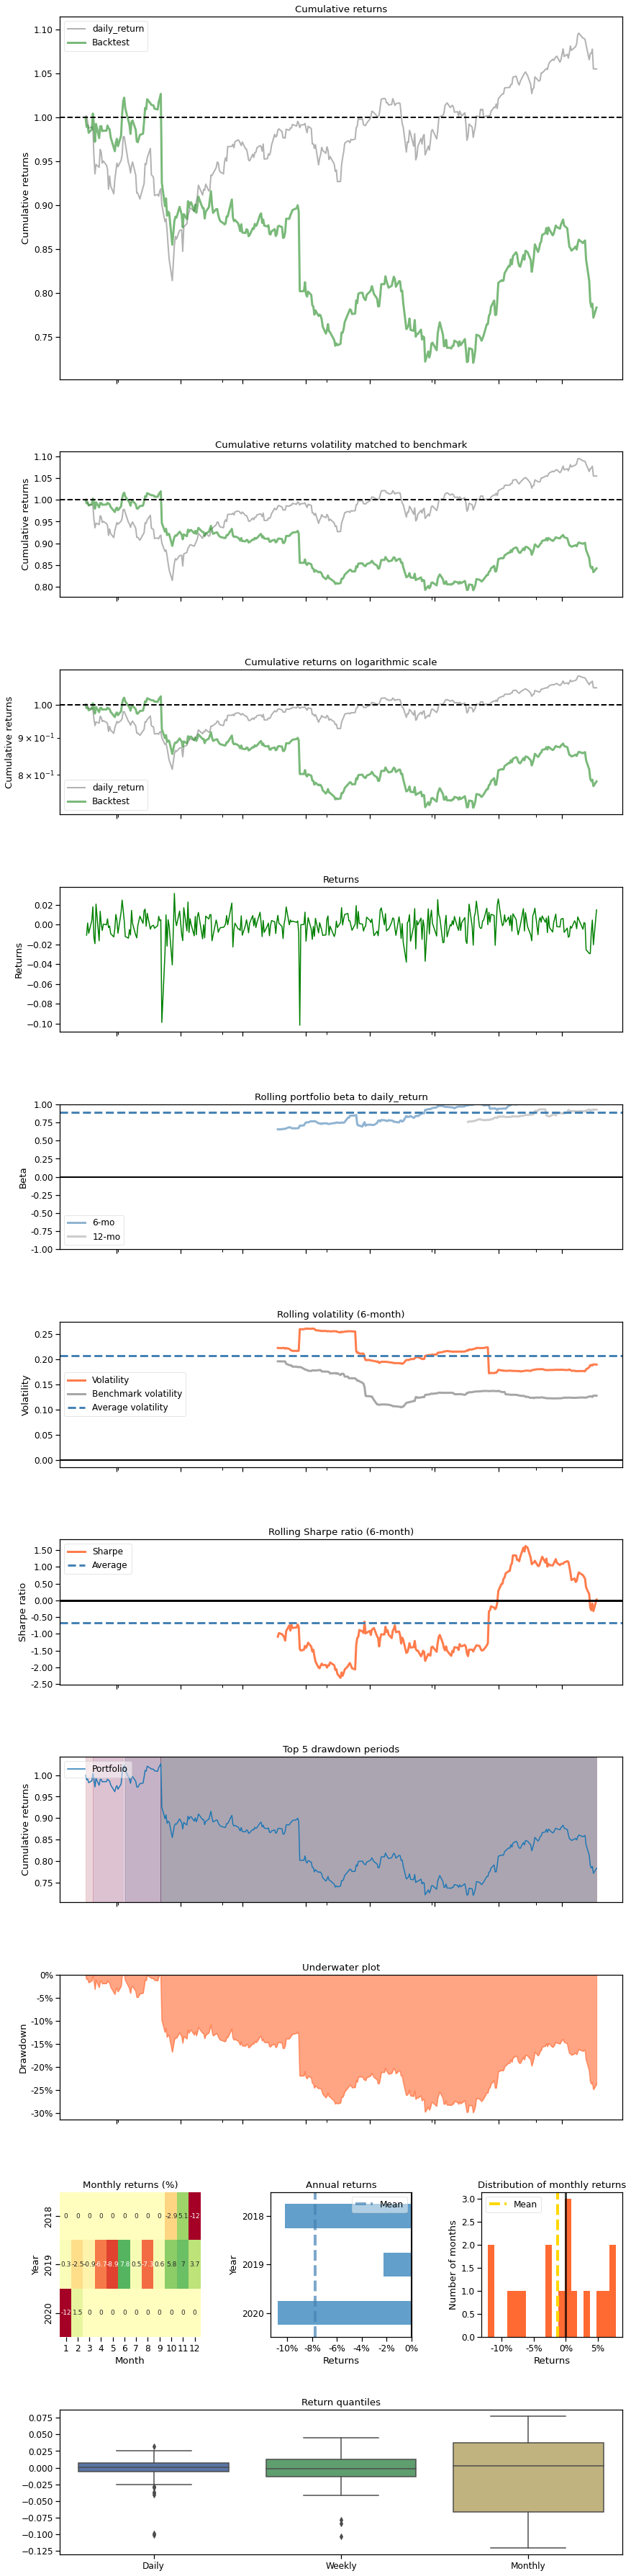

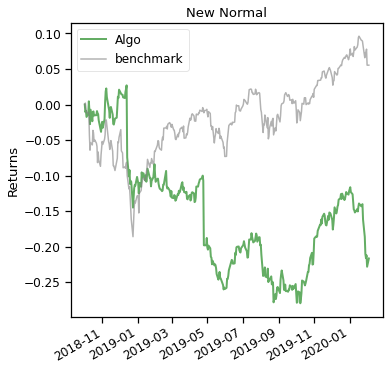

In [182]:
print("==============Compare to DJIA===========")
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_train_trade, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_train_trade.loc[0,'date'],
             baseline_end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])

==============Compare to S&P 500===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2018-10-02
End date,2020-02-03
Total months,16
,Backtest
Annual return,-16.743%
Cumulative returns,-21.675%
Annual volatility,20.976%
Sharpe ratio,-0.77
Calmar ratio,-0.56
Stability,0.45
Max drawdown,-29.865%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.87,2018-12-13,2019-10-08,NaT,NaN
1,4.97,2018-11-08,2018-11-21,2018-12-13,26
2,4.27,2018-10-09,2018-10-30,2018-11-07,22
3,1.75,2018-10-02,2018-10-05,2018-10-09,6
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,-0.06%,-10.17%,3.16%


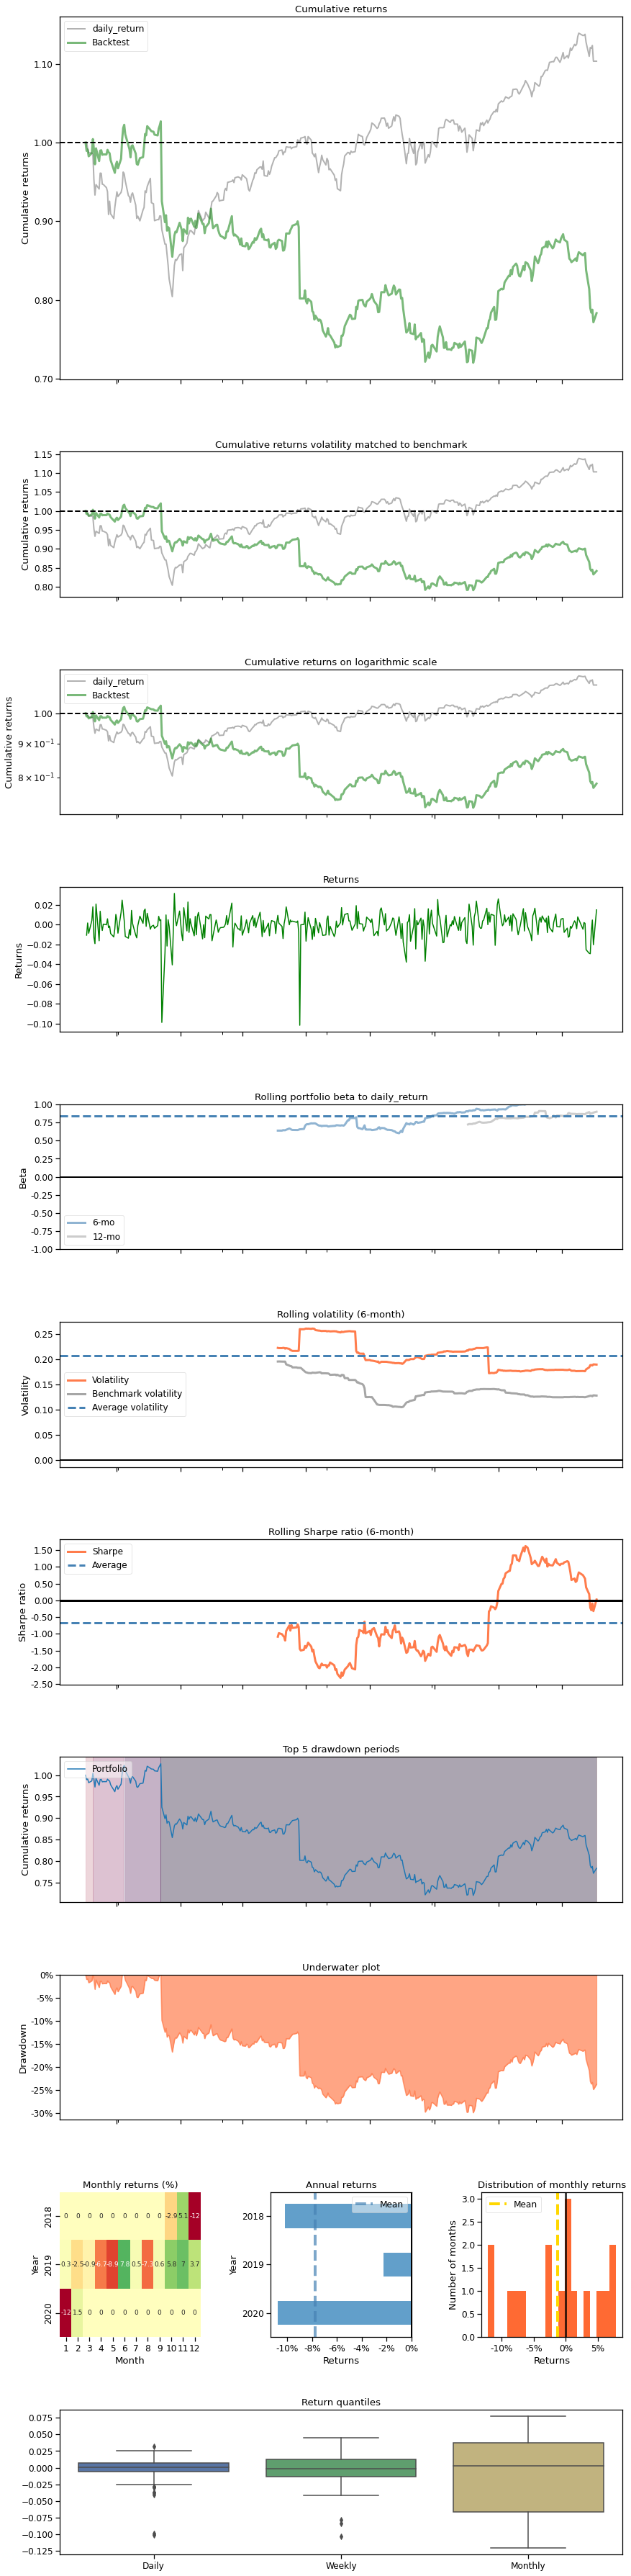

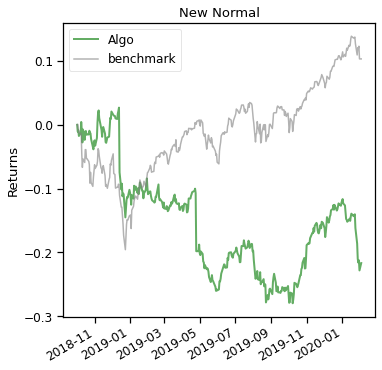

In [183]:
print("==============Compare to S&P 500===========")
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_train_trade, 
             baseline_ticker = '^GSPC', 
             baseline_start = df_account_value_train_trade.loc[0,'date'],
             baseline_end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])

==============Compare to NASDAQ 100===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2018-10-02
End date,2020-02-03
Total months,16
,Backtest
Annual return,-16.743%
Cumulative returns,-21.675%
Annual volatility,20.976%
Sharpe ratio,-0.77
Calmar ratio,-0.56
Stability,0.45
Max drawdown,-29.865%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.87,2018-12-13,2019-10-08,NaT,NaN
1,4.97,2018-11-08,2018-11-21,2018-12-13,26
2,4.27,2018-10-09,2018-10-30,2018-11-07,22
3,1.75,2018-10-02,2018-10-05,2018-10-09,6
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,-0.06%,-10.17%,3.16%


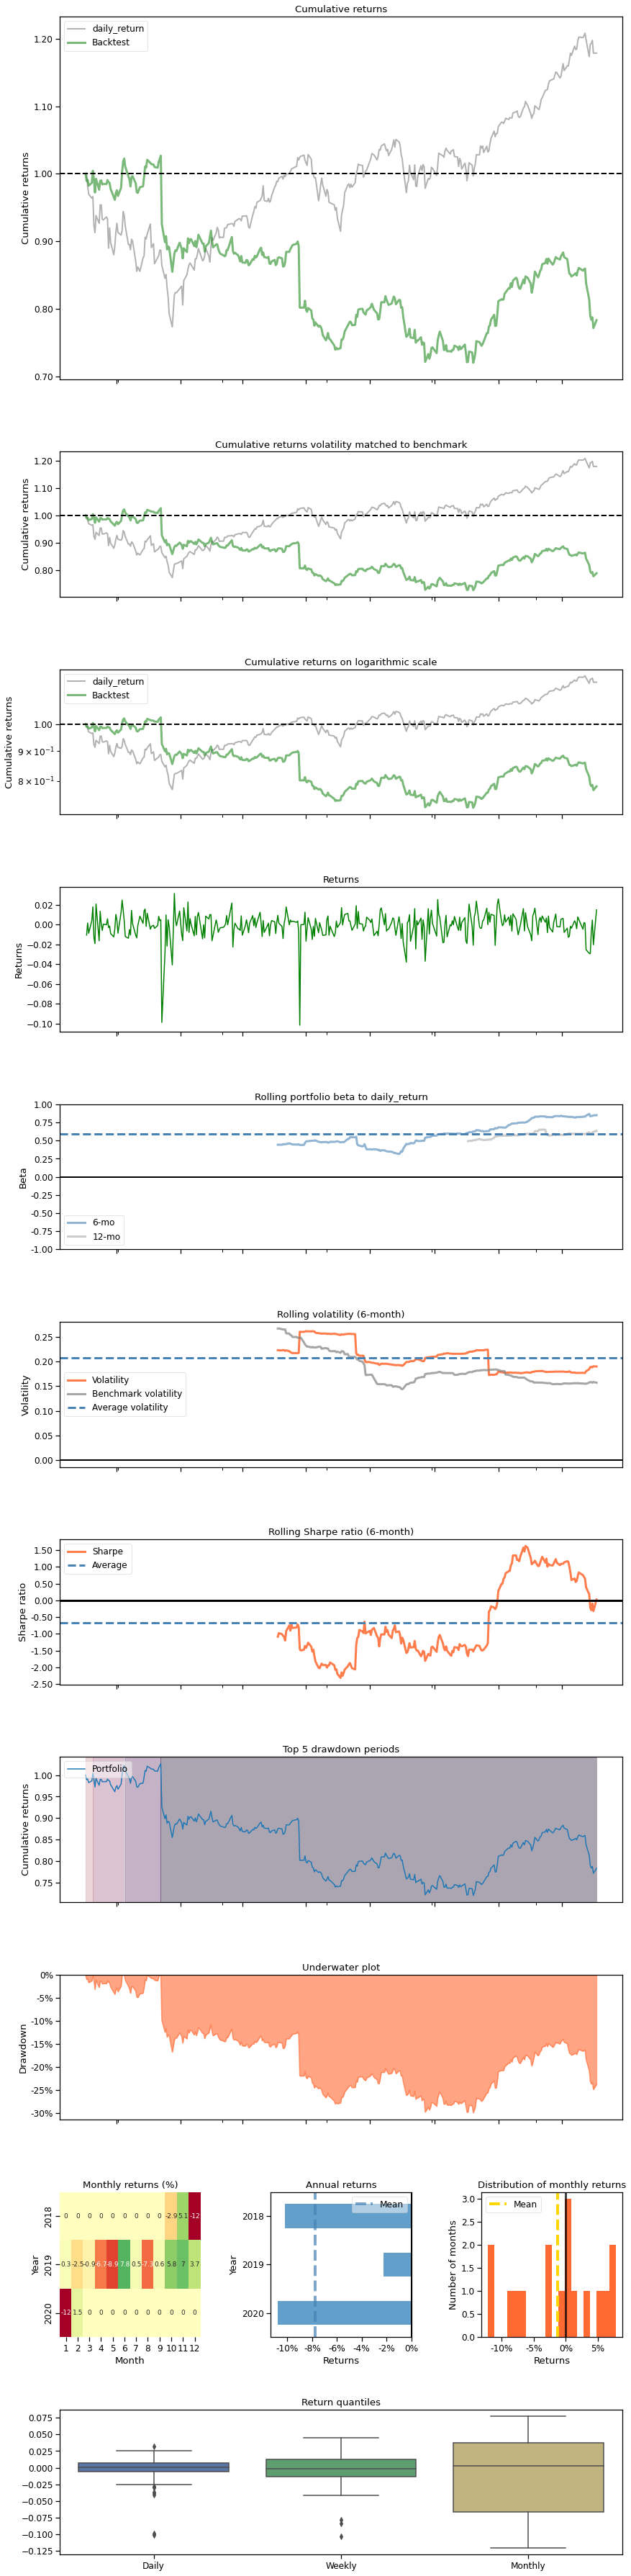

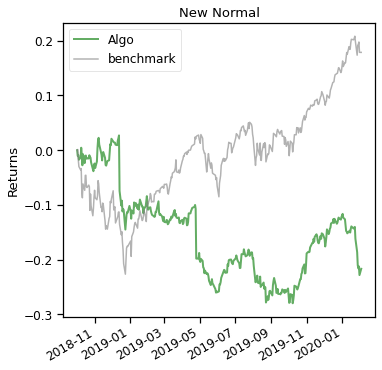

In [184]:
print("==============Compare to NASDAQ 100===========")
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_train_trade, 
             baseline_ticker = '^NDX', 
             baseline_start = df_account_value_train_trade.loc[0,'date'],
             baseline_end = df_account_value_train_trade.loc[len(df_account_value_train_trade)-1,'date'])